FINAL MODEL TRAINING PIPELINE (FULL VERSION WITH VISUALIZATIONS)
Numeric feature count: 39
Training samples: 667
Testing samples:  167
✔ Train-test indices saved.

🟦 Training Multinomial Naive Bayes...
   ✔ NB model trained.

🟩 Training Logistic Regression...
   ✔ LR model trained.

🟧 Training Random Forest (Calibrated)...
   ✔ RF model trained & calibrated.

🤝 Building Soft Voting Ensemble...
   ✔ Ensemble predictions completed.

📊 MODEL PERFORMANCE

--- Comparison Table ---
NB           | Accuracy: 0.7006 | Macro F1: 0.4605
LR           | Accuracy: 0.9102 | Macro F1: 0.7957
RF           | Accuracy: 0.9701 | Macro F1: 0.8926
Ensemble     | Accuracy: 0.9760 | Macro F1: 0.9230

Classification Report (Ensemble):

              precision    recall  f1-score   support

    Negative       0.97      1.00      0.99        66
     Neutral       1.00      0.67      0.80         9
    Positive       0.98      0.99      0.98        92

    accuracy                           0.98       167
   macr

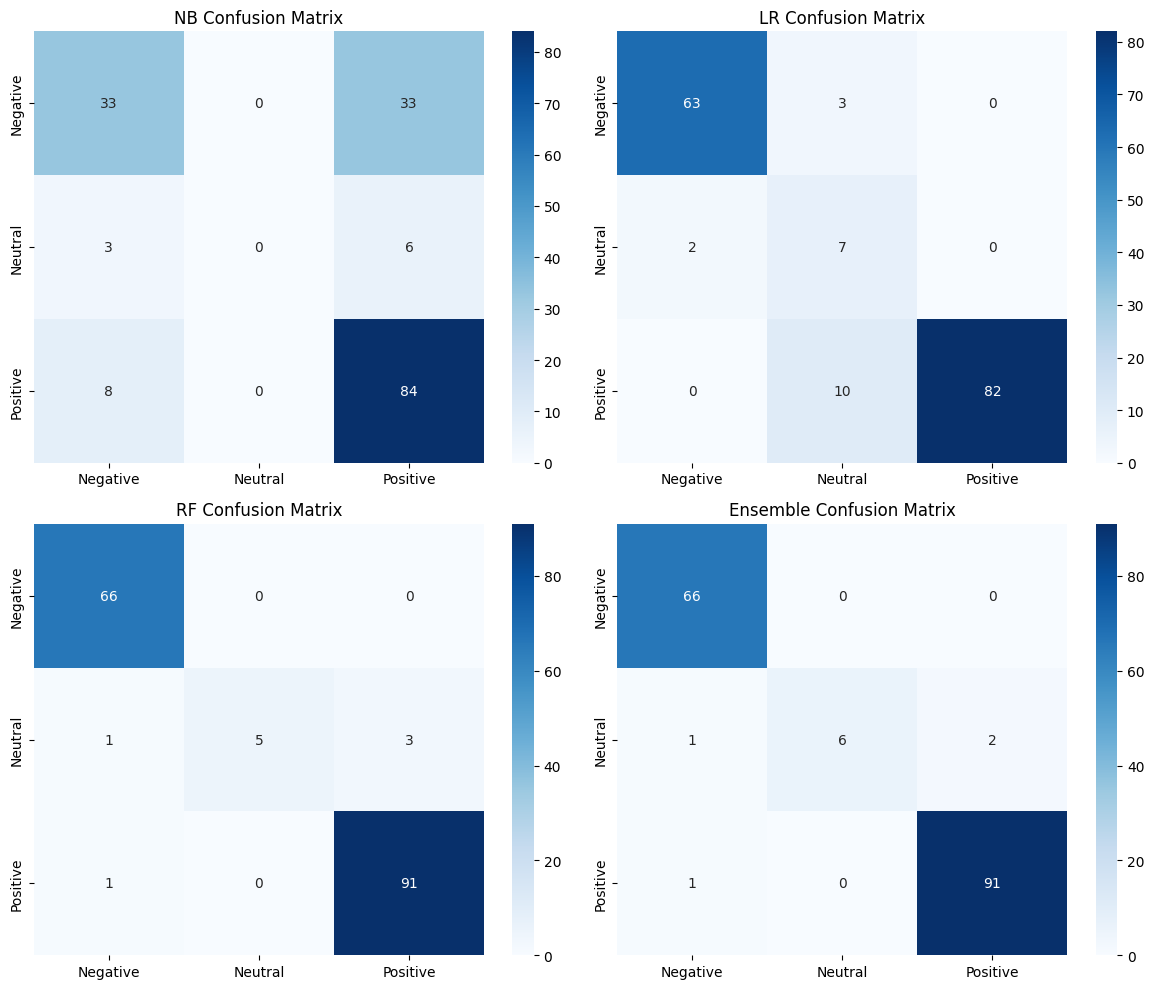

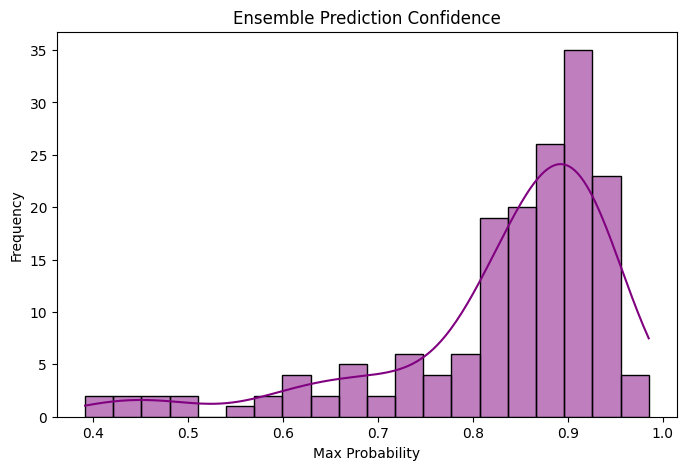

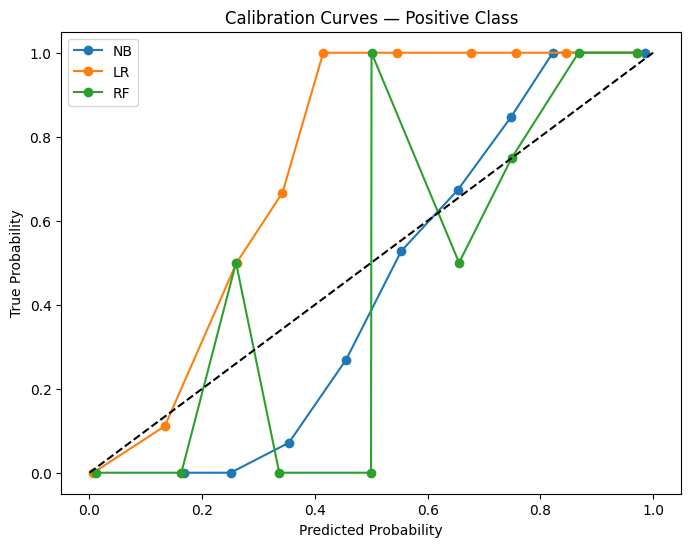

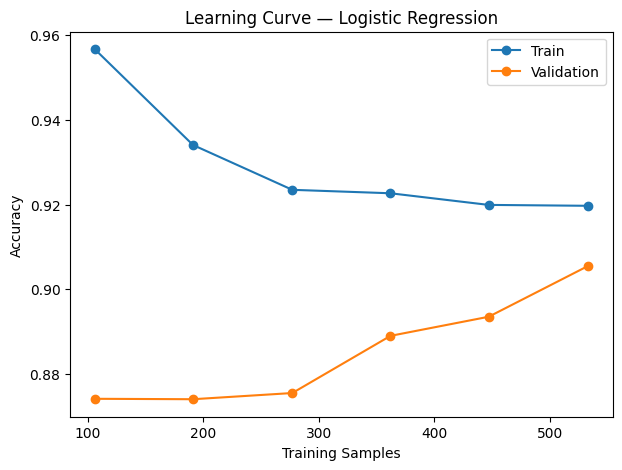

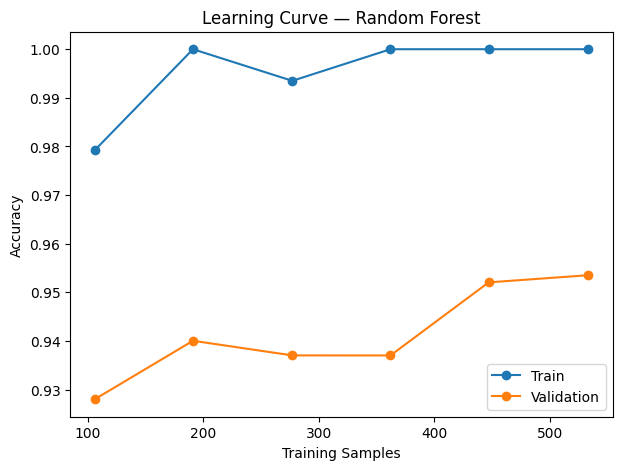

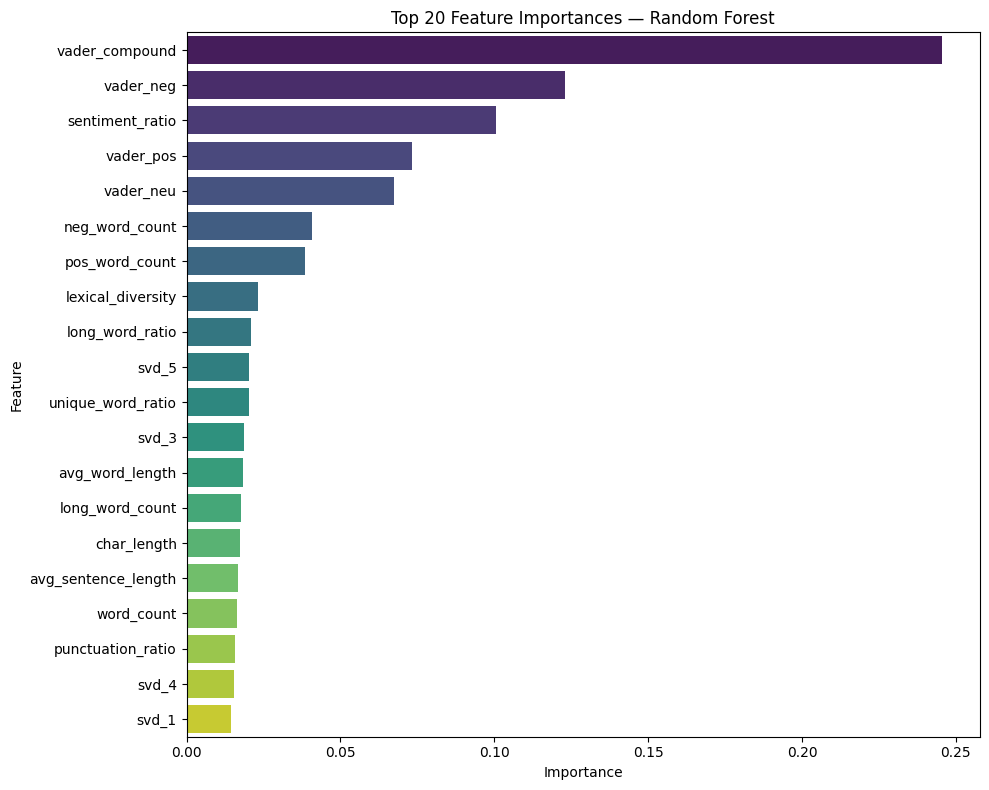

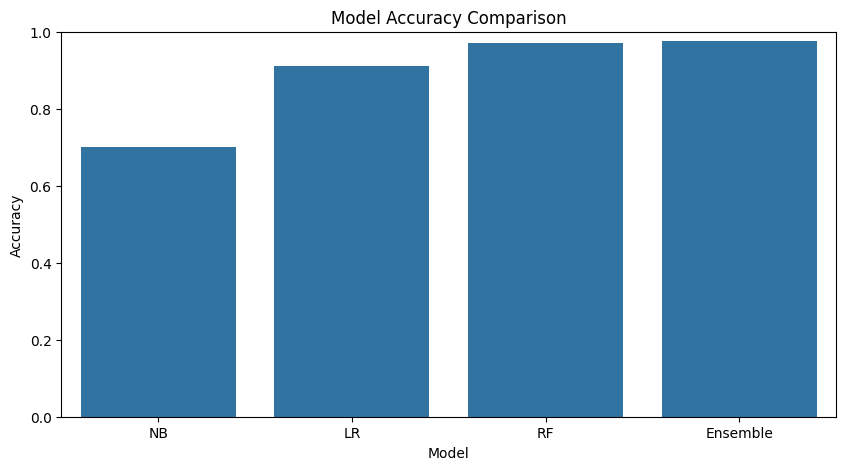

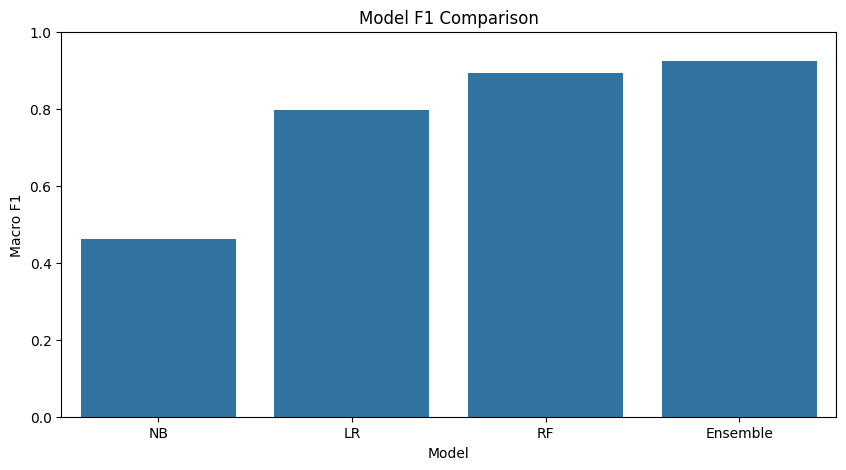


Model Comparison Table:


,Model,Accuracy,Macro F1
0,NB,0.700599,0.460465
1,LR,0.910180,0.795706
2,RF,0.970060,0.892618
3,Ensemble,0.976048,0.922953



💾 Saving trained models...
✔ All models saved successfully!


In [9]:

# ================================================================
# MODEL TRAINING PIPELINE (FINAL, STABLE, INTEGRATED VERSION)
# News Mood Prediction System — No Deep Learning / No Boosting
# ================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import (
    classification_report, confusion_matrix,
    f1_score, accuracy_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore")

print("="*70)
print("FINAL MODEL TRAINING PIPELINE (FULL VERSION WITH VISUALIZATIONS)")
print("="*70)

# ---------------------------------------------------------------
# 1) LOAD ENGINEERED FEATURES
# ---------------------------------------------------------------
df = pd.read_csv("../data/engineered_features.csv")

y = df["sentiment_category"].astype(str)

clean_texts = df["cleaned_text"].copy()

remove_cols = [
    "sentiment_category", "cleaned_text",
    "published_at", "dominant_emotion", "aggregate_sentiment"
]
df = df.drop(columns=[c for c in remove_cols if c in df.columns])

X = df.select_dtypes(include=[np.number])
print(f"Numeric feature count: {X.shape[1]}")

# ---------------------------------------------------------------
# 2) TRAIN–TEST SPLIT
# ---------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples:  {len(X_test)}")

indices = {
    "train_idx": X_train.index,
    "test_idx": X_test.index
}

pickle.dump(indices, open("../models/train_test_indices.pkl", "wb"))
print("✔ Train-test indices saved.")

# ---------------------------------------------------------------
# 3) MULTINOMIAL NAIVE BAYES — USING TF-IDF TEXT
# ---------------------------------------------------------------
print("\n🟦 Training Multinomial Naive Bayes...")

tfidf = TfidfVectorizer(max_features=3000, stop_words="english")
X_train_tfidf = tfidf.fit_transform(clean_texts.loc[X_train.index])
X_test_tfidf = tfidf.transform(clean_texts.loc[X_test.index])

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
print("   ✔ NB model trained.")

# ---------------------------------------------------------------
# 4) LOGISTIC REGRESSION — Numeric features
# ---------------------------------------------------------------
print("\n🟩 Training Logistic Regression...")

lr_model = Pipeline([
    ("scaler", MinMaxScaler()),
    ("lr", LogisticRegression(max_iter=600, class_weight="balanced", random_state=42))
])

lr_model.fit(X_train, y_train)
print("   ✔ LR model trained.")

# ---------------------------------------------------------------
# 5) RANDOM FOREST — With Probability Calibration
# ---------------------------------------------------------------
print("\n🟧 Training Random Forest (Calibrated)...")

rf_base = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=1,
    class_weight="balanced",
    random_state=42
)

rf_model = CalibratedClassifierCV(rf_base, method="sigmoid", cv=3)
rf_model.fit(X_train, y_train)

print("   ✔ RF model trained & calibrated.")

# ---------------------------------------------------------------
# 6) SOFT VOTING ENSEMBLE
# ---------------------------------------------------------------
print("\n🤝 Building Soft Voting Ensemble...")

assert list(nb_model.classes_) == list(lr_model.named_steps["lr"].classes_) \
       == list(rf_model.classes_), "Class order mismatch!"

classes = nb_model.classes_

p_nb = nb_model.predict_proba(X_test_tfidf)
p_lr = lr_model.predict_proba(X_test)
p_rf = rf_model.predict_proba(X_test)

final_prob = (0.2 * p_nb + 0.3 * p_lr + 0.5 * p_rf)

y_pred_ensemble = classes[np.argmax(final_prob, axis=1)]

print("   ✔ Ensemble predictions completed.")

# ---------------------------------------------------------------
# 7) MODEL PERFORMANCE SUMMARY
# ---------------------------------------------------------------
print("\n📊 MODEL PERFORMANCE")

results = {
    "NB": nb_model.predict(X_test_tfidf),
    "LR": lr_model.predict(X_test),
    "RF": rf_model.predict(X_test),
    "Ensemble": y_pred_ensemble
}

print("\n--- Comparison Table ---")
for name, pred in results.items():
    print(f"{name:12s} | Accuracy: {accuracy_score(y_test, pred):.4f} | "
          f"Macro F1: {f1_score(y_test, pred, average='macro'):.4f}")

print("\nClassification Report (Ensemble):\n")
print(classification_report(y_test, y_pred_ensemble))

# ---------------------------------------------------------------
# 7B) CROSS-VALIDATION EVALUATION (NEW BLOCK)
# ---------------------------------------------------------------
print("\n📘 PERFORMING 5-FOLD CROSS-VALIDATION ON TRAINING SET")

from sklearn.model_selection import cross_val_score

# -------------------------------
# Logistic Regression CV
# -------------------------------
print("\n🔹 Logistic Regression — 5-Fold CV")
cv_lr = cross_val_score(
    lr_model, 
    X_train, 
    y_train, 
    cv=5, 
    scoring="accuracy", 
    n_jobs=-1
)
print("LR CV Accuracy Scores:", cv_lr)
print("LR Mean CV Accuracy:", round(cv_lr.mean(), 4), 
      " (+/- ", round(cv_lr.std(), 4), ")")

# -------------------------------
# Random Forest CV (Use Base RF — Not Calibrated)
# -------------------------------
print("\n🔹 Random Forest — 5-Fold CV (Uncalibrated Base Model)")
cv_rf = cross_val_score(
    rf_base,        # Must use uncalibrated RF
    X_train, 
    y_train, 
    cv=5, 
    scoring="accuracy", 
    n_jobs=-1
)
print("RF CV Accuracy Scores:", cv_rf)
print("RF Mean CV Accuracy:", round(cv_rf.mean(), 4), 
      " (+/- ", round(cv_rf.std(), 4), ")")

# -------------------------------
# Naive Bayes CV (TF-IDF text model)
# -------------------------------
print("\n🔹 Naive Bayes — 5-Fold CV (TF-IDF Only)")

# Rebuild TF-IDF training matrix for CV
X_full_tfidf = tfidf.fit_transform(clean_texts.loc[X_train.index])

# CV on NB (text-only model)
cv_nb = cross_val_score(
    nb_model, 
    X_full_tfidf, 
    y_train, 
    cv=5, 
    scoring="accuracy", 
    n_jobs=-1
)

print("NB CV Accuracy Scores:", cv_nb)
print("NB Mean CV Accuracy:", round(cv_nb.mean(), 4),
      " (+/- ", round(cv_nb.std(), 4), ")")

print("\n📘 Cross-Validation Complete.")



# ---------------------------------------------------------------
# 8) ADVANCED VISUALIZATIONS
# ---------------------------------------------------------------
print("\n📈 Creating advanced visualizations...")

# ---------------------------------------------------------------
# A) Confusion Matrices for ALL MODELS
# ---------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for ax, (name, preds) in zip(axes, results.items()):
    cm = confusion_matrix(y_test, preds, labels=classes)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
                xticklabels=classes, yticklabels=classes, ax=ax)
    ax.set_title(f"{name} Confusion Matrix")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# B) Ensemble Confidence Distribution
# ---------------------------------------------------------------
confidence = final_prob.max(axis=1)
plt.figure(figsize=(8,5))
sns.histplot(confidence, bins=20, kde=True, color="purple")
plt.title("Ensemble Prediction Confidence")
plt.xlabel("Max Probability")
plt.ylabel("Frequency")
plt.show()

# ---------------------------------------------------------------
# C) Calibration Curves (Probability Reliability)
# ---------------------------------------------------------------
plt.figure(figsize=(8,6))

for name, probs in [
    ("NB", p_nb),
    ("LR", p_lr),
    ("RF", p_rf)
]:
    prob_pos = probs[:, list(classes).index("Positive")]
    true_prob, pred_prob = calibration_curve((y_test == "Positive"), prob_pos, n_bins=10)
    plt.plot(pred_prob, true_prob, marker="o", label=name)

plt.plot([0,1],[0,1],"k--")
plt.title("Calibration Curves — Positive Class")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.legend()
plt.show()

# ---------------------------------------------------------------
# D) Learning Curves for LR & RF
# ---------------------------------------------------------------
def plot_learning_curve(estimator, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_train, y_train, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.2, 1.0, 6)
    )
    plt.figure(figsize=(7,5))
    plt.plot(train_sizes, train_scores.mean(axis=1), "o-", label="Train")
    plt.plot(train_sizes, test_scores.mean(axis=1), "o-", label="Validation")
    plt.title(title)
    plt.xlabel("Training Samples")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_learning_curve(lr_model, "Learning Curve — Logistic Regression")
plot_learning_curve(rf_model, "Learning Curve — Random Forest")

# ---------------------------------------------------------------
# E) Random Forest — Top 20 Feature Importances
# ---------------------------------------------------------------

# Extract underlying RandomForest from CalibratedClassifierCV
rf_inner = rf_model.calibrated_classifiers_[0].estimator

importances = rf_inner.feature_importances_

fi_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(x="Importance", y="Feature", data=fi_df.head(20), palette="viridis")
plt.title("Top 20 Feature Importances — Random Forest")
plt.tight_layout()
plt.show()



# ---------------------------------------------------------------
# F) Model Comparison Chart
# ---------------------------------------------------------------
comparison_df = pd.DataFrame({
    "Model": ["NB", "LR", "RF", "Ensemble"],
    "Accuracy": [
        accuracy_score(y_test, results["NB"]),
        accuracy_score(y_test, results["LR"]),
        accuracy_score(y_test, results["RF"]),
        accuracy_score(y_test, results["Ensemble"])
    ],
    "Macro F1": [
        f1_score(y_test, results["NB"], average='macro'),
        f1_score(y_test, results["LR"], average='macro'),
        f1_score(y_test, results["RF"], average='macro'),
        f1_score(y_test, results["Ensemble"], average='macro')
    ]
})

plt.figure(figsize=(10,5))
sns.barplot(x="Model", y="Accuracy", data=comparison_df)
plt.ylim(0,1)
plt.title("Model Accuracy Comparison")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x="Model", y="Macro F1", data=comparison_df)
plt.ylim(0,1)
plt.title("Model F1 Comparison")
plt.show()

print("\nModel Comparison Table:")
display(comparison_df)

# ---------------------------------------------------------------
# 9) SAVE MODELS
# ---------------------------------------------------------------
print("\n💾 Saving trained models...")

pickle.dump(nb_model, open("../models/nb_model.pkl", "wb"))
pickle.dump(lr_model, open("../models/lr_model.pkl", "wb"))
pickle.dump(rf_model, open("../models/rf_model.pkl", "wb"))
pickle.dump(tfidf, open("../models/tfidf_vectorizer.pkl", "wb"))
pickle.dump(classes, open("../models/class_labels.pkl", "wb"))

print("✔ All models saved successfully!")
print("="*70)
